In [5]:
import cv2
import numpy as np
import os
from scipy import fftpack


In [19]:
def cropTxtOnly(image):
    # cv2.imshow(image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    
    img = image[30:-450,20:-20] # Perform pre-cropping

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = 255*(gray < 90).astype(np.uint8) # To invert the text to white
    gray = cv2.morphologyEx(gray, cv2.MORPH_OPEN, np.ones((2, 2), dtype=np.uint8)) # Perform noise filtering

    coords = cv2.findNonZero(gray) # Find all non-zero points (text)
    x, y, w, h = cv2.boundingRect(coords) # Find minimum spanning bounding box
    rect = img[y:y+h, x:x+w] # Crop the image - note we do this on the original image
    return rect


In [20]:

def getLineTextFromImg():
    
    genders=["Female", "Male"]

    for gender in genders:
        files = os.listdir("our dataset/train/" +gender)

        for file in files:

            foldername=file.split('.')[0]
            if not os.path.exists("preprocessed/"+gender+'/'+foldername):
                os.makedirs("preprocessed/"+gender+'/'+foldername)

            # load image
            img = cv2.imread("our dataset/train/" + gender + "/" + file )

            #crop the text only from the image
            cropped_img=cropTxtOnly(img)
            cv2.imwrite("preprocessed/"+gender+'/'+foldername+'/'+"cropped.png", cropped_img) # Save the image

            # convert to gray
            gray = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)

            # threshold the grayscale image
            thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

            # use morphology erode to blur horizontally
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (200, 3))
            morph = cv2.morphologyEx(thresh, cv2.MORPH_DILATE, kernel)

            # use morphology open to remove thin lines from dotted lines
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 17))
            morph = cv2.morphologyEx(morph, cv2.MORPH_OPEN, kernel)

            # find contours
            cntrs = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cntrs = cntrs[0] if len(cntrs) == 2 else cntrs[1]

            i=0
            thresh_result = thresh.copy()
            for c in cntrs:
                box = cv2.boundingRect(c)
                x,y,w,h = box
                cv2.imwrite("preprocessed/"+gender+'/'+foldername + "/" + foldername + "-"+str(i)+".jpg", thresh_result[ y:y+h , x:x+w ] )
                i+=1


            # write result to disk
            cv2.imwrite("preprocessed/"+gender+'/'+foldername + "/preprocessed.jpg", thresh)



In [ ]:
# getLineTextFromImg()

In [2]:
def cannyEdgeDetection(image):
    cv2.Canny(image,50,100)

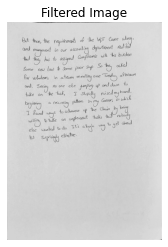

In [21]:
import commonfunctions as cf # this a custom module found the commonfunctions.py

# This function applies a filter to an image in the frequency domain
# and plots multiple images describing the process
def apply_filter_in_freq(img, f):
    img_in_freq = fftpack.fft2(img)
    
    # we supply the img shape here to make both the filter and img have the same shape to be able to multiply
    filter_in_freq = fftpack.fft2(f, img.shape)
    filtered_img_in_freq = np.multiply(img_in_freq, filter_in_freq)
    filtered_img = fftpack.ifft2(filtered_img_in_freq)

    return filtered_img
   
def LPF(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    f1=np.array([
    [1,2,1],
    [2,4,2],
    [1,2,1]
    ])

    filtered_img = apply_filter_in_freq(gray, f1)
    cf.show_images([np.abs(filtered_img)], ['Filtered Image'])
    # cv2.imwrite("F1/LPF.png",np.int64( np.abs(filtered_img) ) )
    # cv2.imshow("filtered_img",np.int8( np.abs(filtered_img) ) )
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()


img = cv2.imread("preprocessed/F1/preprocessed.png")
LPF(img)

